# Trading Earnings Volatility

## Background

Quarterly earning announcements can cause potentially extreme moves in individual equities as companies under/over perform relative to expectation. These are previously announced events with known times, giving both day traders and large institutions the opportunity to place volatility and directional bets in the options marketplace, capitalizing on market reaction and the sentiment to the report.

To highlight this, we can look at the recent underlying volatility surrounding AMZN and GOOG earnings at the start of 2022, with Alphabet reporting after the market close on 2/1 and AMZN reporting after the market close on 2/2.

GOOG rallied from 2757 to 2960, a gain of 7.3% between the earnings report and the close on 2/2. (GOOGL very similar performance)
Amazon dropped from 3012 to 2776, losing more than 8% between the earnings report and the close on 2/3.

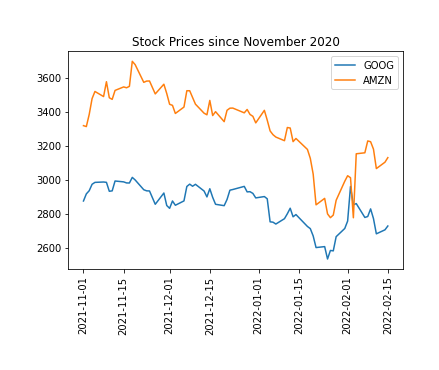

In [1]:
from IPython.display import Image
Image('GOOG_AMZN.png')

## Hypothesis

Stocks experience higher than average realized volatility around quarterly earnings announcements.


The average realized volatility of an individual equity stock through its historical earnings reports relative to its baseline performance is predictive of how much we would expect it to move on an upcoming earnings press release.


If the shortest dated at the money options for an issuer is priced on an implied volatility higher than our prediction for realized volatility going into an earnings, there is a positive expected value in selling the at the money straddle. If the straddle is priced below our prediction for realized volatility, there is a positive expected value position in buying the straddle. 


## Data

We will be using the WRDS OptionsMetrics database to get our data. Specifically, 'OptionMetrics - Historical Volatility' and 'OptionMetrics - Option Prices'.

### Required:
1. Historical earnings dates
2. Daily realized volatility calculations
3. Daily option implied volatilities
4. Daily market close bid/ask prices for the nearest term 50d call and put option

### May Want to Consider:
5. Daily option volumes
6. Earnings data vs expectations

## Strategy Execution

Select a subset of companies that we expect would be a good candidate for this volatility trading strategy. We will select stocks with liquid options markets with earnings announcements that have sparked increased options trading speculation. We also need to select companies that have enough of an earnings history to form a prediction.

For each stock selected:
    1. Compare realized volatility on and the day after earnings announcements to their average realized volatility in the training data set
    2. Calculate an expectation for realized volatility for the future earnings dates in a testing data set and compare it to the implied volatility of the at the money straddle in the day's preceeding the earnings dates.
    3. Construct a sizing curve depending on the difference between implied volatility vs expected realized volatility. Depending on the difference, trade up to 10k notional buying or selling the at the money straddle at the close price BBO.
    4. Close out our straddle position T+1 after earnings date.
    


## Analysis and Data

In [2]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'

#### Select historical adjusted close prices for companies with liquid options markets

In [3]:
#Our option price data ends on 12/31/20 so we will end our analysis on that date.
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

adj_close.head()

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167


#### 

### Financial statement filing date

In [4]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [5]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


#### Historical option data

In [6]:
# this is limited to options with expiry less than 15 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [7]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [8]:
# strike_price = strike * 1000
option_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0.919228,0.986198,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,0.955372,0.975301,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0.695843,0.992689,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0.771536,0.978447,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0.673865,0.981649,106134400,AMZN,0,AMAZON.COM INC.,A


### Analysis

In [337]:
class Earnings_strat():
    
    def __init__(self, filing_dates_df, option_data_df, adj_close_df, vola_window):
        self.filing_dates_df = filing_dates_df
        self.option_data_df = option_data_df
        self.adj_close_df = adj_close_df
        self.vola_window = vola_window
        
    def __calc_rolling_vola(self):
        
        close_vola_df = pd.DataFrame()
        
        for t in self.adj_close_df.ticker.unique():
            df = self.adj_close_df[self.adj_close_df['ticker'] == t]
            df = (df['adj_close'].rolling(self.vola_window).std() * np.sqrt(252)) / df['adj_close']
            close_vola_df = pd.concat([close_vola_df, df], axis = 0)
            
        close_vola_df=close_vola_df.rename(columns={0:"vola_{}day".format(self.vola_window)})
        close_vola_df = pd.concat([self.adj_close_df, close_vola_df], axis = 1)
        
        return close_vola_df
    
    # this function returns the 50 delta calls and puts for exdate immediately after filing_date
    def __filter_opts(self):
                
        self.opt_expiry = {}
        result = pd.DataFrame(columns = ['ticker', 'filing_date', 'exdate'])
        
        # find option expiring after earnings date
        for s in self.option_data_df['ticker'].unique():
        
            filing = pd.DataFrame(self.filing_dates_df[self.filing_dates_df['ticker'] == s])
            options = pd.DataFrame(self.option_data_df[self.option_data_df['ticker'] == s])
    
            options['exdate'] = pd.to_datetime(options['exdate'])
            filing['filing_date'] = pd.to_datetime(filing['filing_date'])
        
            # want options that expire after filing date
            filing['filing_date'] = filing['filing_date'] + pd.Timedelta('1 days')
        
            filing_exdate = []
        
            for d in filing['filing_date']:
                try:
                    date = options[options['exdate'] >= d].head(1).exdate.item()
                    
                    result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
                                          ignore_index = True)
                except ValueError: # error raised if no option expiry after final filing date
                    continue

        result['filing_date'] = pd.to_datetime(result['filing_date'])
        result['exdate'] = pd.to_datetime(result['exdate'])
        self.filing_dates_df = pd.DataFrame(result)
        
        self.option_data_df['exdate'] = pd.to_datetime(self.option_data_df['exdate'])
        
        # merge on exdate just after filing_dates
        self.option_data_df = pd.merge(self.option_data_df, self.filing_dates_df,
                                       on = ['ticker', 'exdate'])
        
        # get options closest to delta=50 for each expiry
        res = pd.DataFrame()
        for s in self.option_data_df['ticker'].unique():
            
            call_d, put_d = {}, {}
            
            df = self.option_data_df[self.option_data_df['ticker'] == s]
        
            df = df.set_index('date')
        
            for d in df.index.unique():
                call_i = (abs(df.loc[d]['delta'] - 0.5)).argmin()
                put_i = (abs(df.loc[d]['delta'] + 0.5)).argmin()
                call_d[d] = df.loc[d].iloc[call_i]
                put_d[d] = df.loc[d].iloc[put_i]
            
            calls = pd.DataFrame(call_d).transpose()
            puts = pd.DataFrame(put_d).transpose()
        
            calls.index = pd.to_datetime(calls.index)
            puts.index = pd.to_datetime(puts.index)
            
            temp = pd.concat([calls, puts], axis = 0)
            res = pd.concat([res, temp], axis = 0)
        
        return res
    
    # clean_data returns the daily 50 delta call and put for each symbol
    # and includes the next filing_date, adj_close, and rolling realized vol
    # --> use this data to check implied vol vs realized vol, leading up to filing_date
    # then, identify optionid of call and put of 50 delta straddle
    # then, use self.option_data_df to track price of straddle using optionid's
    def clean_data(self):
        close_vola_df = self.__calc_rolling_vola()
        cleaned_opts = self.__filter_opts()
        
        cleaned_opts = cleaned_opts.reset_index()
        cleaned_opts = cleaned_opts.rename(columns = {'index':'date'})
        
        self.atm_opts = pd.merge(cleaned_opts, close_vola_df, on=['date', 'ticker'])
        return self.atm_opts
            

In [338]:
strat = Earnings_strat(filing_dates, option_data, adj_close, vola_window = 7)

In [339]:
opts = strat.clean_data()

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/2192836543.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append({'ticker': s, 'filing_date': d, 'exdate': date},
/tmp/ipykernel_4968/

In [ ]:
## verify data (everything below can be deleted)

In [348]:
opts = opts.set_index('date')

In [360]:
opts[opts['ticker'] == 'AMZN'].head(50)

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style,filing_date,adj_close,vola_7day
date,,,,,,,,,,,,,,,,
2015-04-17,2015-05-01,C,377500,13.9,14.4,61,0.513112,0.49983,107073414,AMZN,0,AMAZON.COM INC.,A,2015-04-25,375.56,1.151757
2015-04-17,2015-05-01,P,377500,15.8,16.3,87,0.512505,-0.500254,107073452,AMZN,0,AMAZON.COM INC.,A,2015-04-25,375.56,1.151757
2015-04-20,2015-05-01,C,392500,14.5,14.8,92,0.594519,0.49121,107073420,AMZN,0,AMAZON.COM INC.,A,2015-04-25,389.51,1.052467
2015-04-20,2015-05-01,P,392500,17.05,17.5,2,0.581641,-0.509914,107073458,AMZN,0,AMAZON.COM INC.,A,2015-04-25,389.51,1.052467
2015-04-21,2015-05-01,C,392500,15.6,15.85,144,0.632871,0.508221,107073420,AMZN,0,AMAZON.COM INC.,A,2015-04-25,391.18,1.006436
2015-04-21,2015-05-01,P,392500,16.55,16.9,17,0.621103,-0.49243,107073458,AMZN,0,AMAZON.COM INC.,A,2015-04-25,391.18,1.006436
2015-04-22,2015-05-01,C,392500,15.85,16.1,92,0.70574,0.497387,107073420,AMZN,0,AMAZON.COM INC.,A,2015-04-25,389.80,0.904936
2015-04-22,2015-05-01,P,392500,18.4,18.7,18,0.701198,-0.502934,107073458,AMZN,0,AMAZON.COM INC.,A,2015-04-25,389.80,0.904936
2015-04-23,2015-05-01,C,392500,14.15,15.0,203,0.683696,0.495031,107073420,AMZN,0,AMAZON.COM INC.,A,2015-04-25,389.99,0.717762


In [349]:
o=opts[opts['ticker'] == 'AMZN'].loc['2015-04-17':'2015-04-30']

In [350]:
o['filing_date'].unique()

array(['2015-04-25T00:00:00.000000000'], dtype='datetime64[ns]')

<AxesSubplot:xlabel='date'>

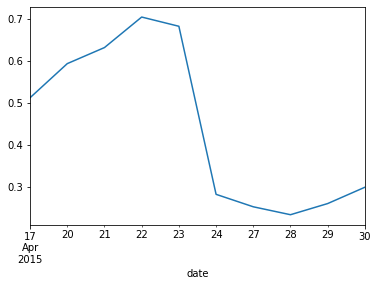

In [351]:
o[o['cp_flag'] == 'C']['impl_volatility'].plot()